In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

In [2]:
usuarios = 1_000

## Genero el dataset

In [3]:
np.random.seed(171)
revenue_anterior = np.random.normal(loc=10, scale=2, size=usuarios)
revenue_base_nuevo = np.random.normal(revenue_anterior, 0.1)
tratamiento = np.random.random(size=usuarios) < 0.5
revenue_nuevo = revenue_base_nuevo + 0.4 * tratamiento
full_dataset = pd.DataFrame(
    {"Tratamiento": tratamiento, "Anterior": revenue_anterior, "Revenue": revenue_nuevo}
)

## Análisis

In [4]:
dataset = full_dataset[["Tratamiento", "Revenue"]]
dataset

,Tratamiento,Revenue
0,True,12.139623
1,True,10.967258
2,False,12.633915
3,False,10.653629
4,True,9.381743
...,...,...
995,True,10.229276
996,False,10.304811
997,False,2.248404
998,True,10.712687


In [5]:
tratado = dataset[dataset["Tratamiento"]]["Revenue"]
control = dataset[~dataset["Tratamiento"]]["Revenue"]

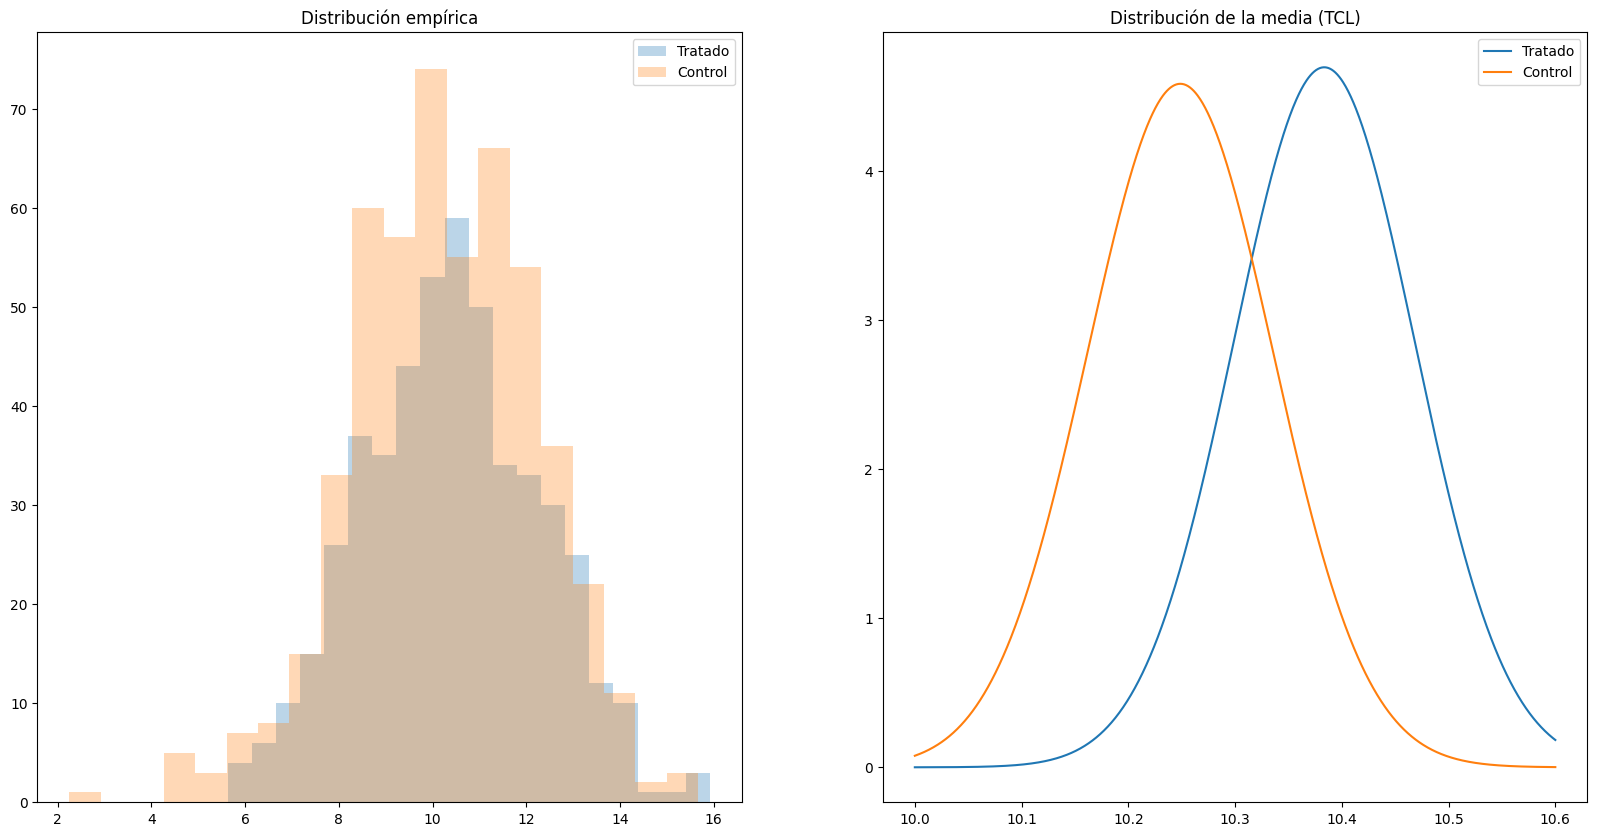

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.hist(tratado, bins=20, alpha=0.3, label="Tratado")
ax1.hist(control, bins=20, alpha=0.3, label="Control")
ax1.legend()
ax1.set_title("Distribución empírica")
x = np.linspace(10.0, 10.6, 1000)
tratado_mean = sp.stats.norm.pdf(
    x, tratado.mean(), tratado.std() / np.sqrt(len(tratado))
)
control_mean = sp.stats.norm.pdf(
    x, control.mean(), control.std() / np.sqrt(len(control))
)

ax2.plot(x, tratado_mean, label="Tratado")
ax2.plot(x, control_mean, label="Control")
ax2.set_title("Distribución de la media (TCL)")
ax2.legend()

In [7]:
sp.stats.ttest_ind(tratado, control)

TtestResult(statistic=np.float64(1.1067699956819392), pvalue=np.float64(0.2686600805650387), df=np.float64(998.0))

In [8]:
from statsmodels.formula.api import ols

model = ols("Revenue ~ Tratamiento", data=dataset)
results = model.fit()

print(results.summary().tables[1])

                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.2487      0.085    120.444      0.000      10.082      10.416
Tratamiento[T.True]     0.1348      0.122      1.107      0.269      -0.104       0.374


## Imputación de valores (versión libre)

### Veamos el dataset entero

In [9]:
full_dataset

,Tratamiento,Anterior,Revenue
0,True,11.591423,12.139623
1,True,10.652942,10.967258
2,False,12.467048,12.633915
3,False,10.685978,10.653629
4,True,8.858674,9.381743
...,...,...,...
995,True,9.747324,10.229276
996,False,10.209973,10.304811
997,False,2.233162,2.248404
998,True,10.369848,10.712687


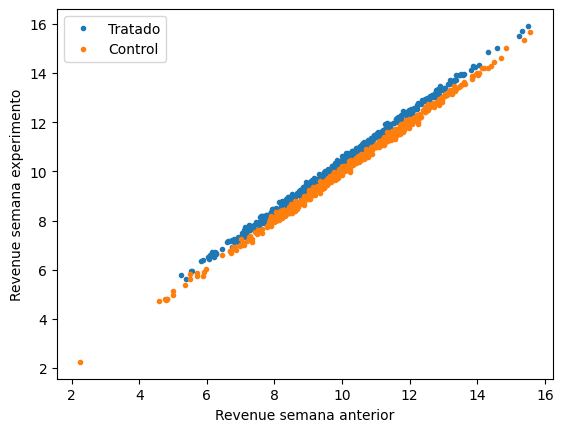

In [10]:
full_tratado = full_dataset[full_dataset["Tratamiento"]]
full_control = full_dataset[~full_dataset["Tratamiento"]]

fig, ax = plt.subplots()
ax.plot(
    full_tratado["Anterior"],
    full_tratado["Revenue"],
    label="Tratado",
    marker=".",
    linestyle="none",
)
ax.plot(
    full_control["Anterior"],
    full_control["Revenue"],
    label="Control",
    marker=".",
    linestyle="none",
)
ax.set_xlabel("Revenue semana anterior")
ax.set_ylabel("Revenue semana experimento")
ax.legend()

In [11]:
model = ols("Revenue ~ Anterior", data=full_dataset)
results = model.fit()

print(results.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3055      0.037      8.264      0.000       0.233       0.378
Anterior       0.9898      0.004    275.689      0.000       0.983       0.997


In [12]:
full_dataset["Diferencia"] = full_dataset["Revenue"] - (
    results.params["Anterior"] * full_dataset["Anterior"] + results.params["Intercept"]
)

In [13]:
full_tratado_dif = full_dataset["Diferencia"][full_dataset["Tratamiento"]]
full_control_dif = full_dataset["Diferencia"][~full_dataset["Tratamiento"]]
print(sp.stats.ttest_ind(full_tratado_dif, full_control_dif))
print(full_tratado_dif.mean() - full_control_dif.mean())

TtestResult(statistic=np.float64(62.76870106383935), pvalue=np.float64(0.0), df=np.float64(998.0))
0.3915525472064363


(array([  2.,  11.,  28.,  53., 102., 129., 103.,  52.,  26.,   6.]),
 array([-0.50902544, -0.45008202, -0.3911386 , -0.33219517, -0.27325175,
        -0.21430833, -0.15536491, -0.09642149, -0.03747807,  0.02146535,
         0.08040877]),
 <BarContainer object of 10 artists>)

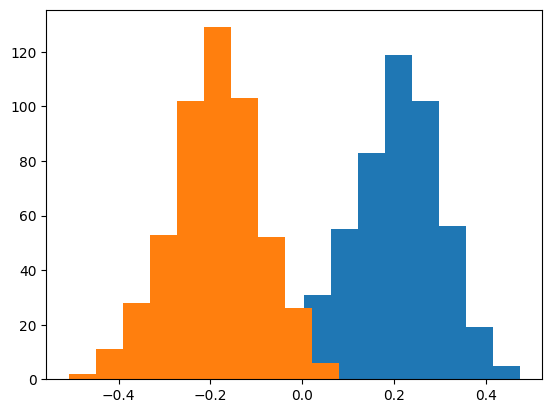

In [14]:
fig, ax = plt.subplots()
ax.hist(full_tratado_dif)
ax.hist(full_control_dif)

In [15]:
full_dataset["Diferencia"] = full_dataset["Revenue"] - full_dataset["Anterior"]
full_tratado = full_dataset[full_dataset["Tratamiento"]]
full_control = full_dataset[~full_dataset["Tratamiento"]]

In [16]:
model = ols("Diferencia ~ Tratamiento", data=full_dataset)
results = model.fit()

print(results.summary().tables[1])

                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0104      0.004      2.396      0.017       0.002       0.019
Tratamiento[T.True]     0.3942      0.006     63.626      0.000       0.382       0.406


In [17]:
model = ols("Revenue ~ Tratamiento + Anterior", data=full_dataset)
results = model.fit()

print(results.summary().tables[1])

                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0445      0.017      2.618      0.009       0.011       0.078
Tratamiento[T.True]     0.3933      0.006     63.448      0.000       0.381       0.405
Anterior                0.9967      0.002    621.339      0.000       0.994       1.000


## ANCOVA2

In [18]:
np.random.seed(171)
revenue_anterior = np.random.normal(loc=10, scale=2, size=usuarios)
revenue_base_nuevo = np.random.normal(revenue_anterior, 0.1)
tratamiento = np.random.random(size=usuarios) < 0.5
revenue_nuevo = (
    revenue_base_nuevo
    + 0.02 * tratamiento
    + 0.1 * (revenue_base_nuevo - np.mean(revenue_base_nuevo)) * tratamiento
)
full_dataset = pd.DataFrame(
    {"Tratamiento": tratamiento, "Anterior": revenue_anterior, "Revenue": revenue_nuevo}
)

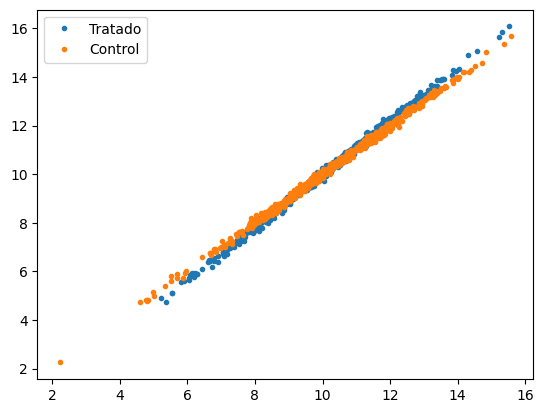

In [19]:
full_tratado = full_dataset[full_dataset["Tratamiento"]]
full_control = full_dataset[~full_dataset["Tratamiento"]]

fig, ax = plt.subplots()
ax.plot(
    full_tratado["Anterior"],
    full_tratado["Revenue"],
    label="Tratado",
    marker=".",
    linestyle="none",
)
ax.plot(
    full_control["Anterior"],
    full_control["Revenue"],
    label="Control",
    marker=".",
    linestyle="none",
)
ax.legend()

In [20]:
full_dataset["Desplazado"] = full_dataset["Anterior"] - np.mean(
    full_dataset["Anterior"]
)
model = ols(
    "Revenue ~ Tratamiento + Desplazado + Desplazado:Tratamiento", data=full_dataset
)
results = model.fit()

print(results.summary().tables[1])

                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         10.1230      0.005   2229.878      0.000      10.114      10.132
Tratamiento[T.True]                0.0131      0.007      2.019      0.044       0.000       0.026
Desplazado                         0.9935      0.002    433.837      0.000       0.989       0.998
Desplazado:Tratamiento[T.True]     0.1070      0.003     31.704      0.000       0.100       0.114


In [21]:
model = ols("Revenue ~ Tratamiento + Desplazado", data=full_dataset)
results = model.fit()

print(results.summary().tables[1])

                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.1167      0.006   1574.447      0.000      10.104      10.129
Tratamiento[T.True]     0.0117      0.009      1.270      0.204      -0.006       0.030
Desplazado              1.0427      0.002    437.606      0.000       1.038       1.047


In [22]:
np.random.seed(171)
revenue_anterior = np.random.normal(loc=10, scale=2, size=usuarios)
revenue_base_nuevo = np.random.normal(revenue_anterior, 0.1)
tratamiento = np.random.random(size=usuarios) < 0.5
revenue_nuevo = revenue_base_nuevo + 0.02 * tratamiento
full_dataset = pd.DataFrame(
    {"Tratamiento": tratamiento, "Anterior": revenue_anterior, "Revenue": revenue_nuevo}
)

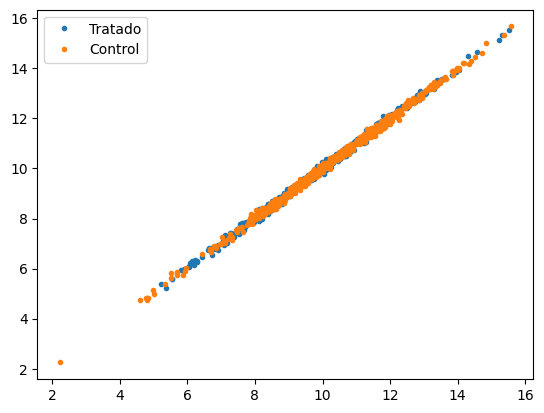

In [23]:
full_tratado = full_dataset[full_dataset["Tratamiento"]]
full_control = full_dataset[~full_dataset["Tratamiento"]]

fig, ax = plt.subplots()
ax.plot(
    full_tratado["Anterior"],
    full_tratado["Revenue"],
    label="Tratado",
    marker=".",
    linestyle="none",
)
ax.plot(
    full_control["Anterior"],
    full_control["Revenue"],
    label="Control",
    marker=".",
    linestyle="none",
)
ax.legend()

In [24]:
full_dataset["Desplazado"] = full_dataset["Anterior"] - np.mean(
    full_dataset["Anterior"]
)
model = ols(
    "Revenue ~ Tratamiento + Desplazado + Desplazado:Tratamiento", data=full_dataset
)
results = model.fit()

print(results.summary().tables[1])

                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         10.1230      0.004   2342.378      0.000      10.114      10.131
Tratamiento[T.True]                0.0134      0.006      2.168      0.030       0.001       0.026
Desplazado                         0.9935      0.002    455.724      0.000       0.989       0.998
Desplazado:Tratamiento[T.True]     0.0069      0.003      2.160      0.031       0.001       0.013


In [25]:
model = ols("Revenue ~ Tratamiento + Desplazado", data=full_dataset)
results = model.fit()

print(results.summary().tables[1])

                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.1226      0.004   2340.187      0.000      10.114      10.131
Tratamiento[T.True]     0.0133      0.006      2.149      0.032       0.001       0.025
Desplazado              0.9967      0.002    621.339      0.000       0.994       1.000
